# [01] Task 1. MC and TD(0) state value & Draw the curve

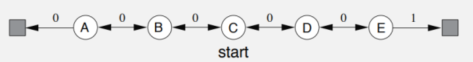

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
This script implements and compares Monte Carlo (MC) and Temporal-Difference (TD(0))
prediction algorithms on a simple Random Walk Markov Reward Process (MRP).

The MRP is defined as follows:
- States: A, B, C, D, E (indexed 0 to 4).
- All episodes start in the center state, C.
- On each step, the agent moves left or right with equal probability (50%).
- Episodes terminate when moving left from state A or right from state E.
- A reward of +1 is given for terminating on the right (from E). All other rewards are 0.
- The true state values are V(s) = (s+1) / 6 for s in {A,B,C,D,E}.
"""
class RandomWalkMRP:
    """
    Implements the Random Walk MRP environment.
    States are represented by indices 0 (A) through 4 (E).
    """
    def __init__(self):
        self.num_states = 5
        self.start_state = 2 # State C
        # The true values of states A, B, C, D, E
        self.true_values = np.arange(1, self.num_states + 1) / (self.num_states + 1.0)
        self.state_labels = ['A', 'B', 'C', 'D', 'E']

    def step(self, state):
        """
        Performs one step in the environment from the given state.

        Args:
            state (int): The current state index.

        Returns:
            tuple: A tuple containing (next_state, reward, is_done).
                next_state is an integer, reward is a float, is_done is a boolean.
        """
        if np.random.rand() < 0.5:
            # Move left
            next_state = state - 1
        else:
            # Move right
            next_state = state + 1

        reward = 0
        is_done = False

        if next_state < 0:
            is_done = True
            # Reward remains 0 for terminating on the left
        elif next_state >= self.num_states:
            is_done = True
            reward = 1.0 # Reward is +1 for terminating on the right

        return next_state, reward, is_done

In [3]:
def monte_carlo_prediction(env, num_episodes, alpha, gamma=1.0):
    """
    Implements the every-visit Monte Carlo prediction algorithm.

    Args:
        env (RandomWalkMRP): The environment.
        num_episodes (int): The number of episodes to run.
        alpha (float): The learning rate.
        gamma (float): The discount factor.

    Returns:
        tuple: A tuple containing the final value function (V) and the history
            of value estimates over episodes.
    """
    # Initialize values: 0 for terminal states, 0.5 for non-terminal
    V = np.full(env.num_states, 0.5)
    value_history = np.zeros((num_episodes, env.num_states))

    for episode in range(num_episodes):
        # Generate a complete episode trajectory
        trajectory = []
        state = env.start_state
        is_done = False

        while not is_done:
            trajectory.append(state)
            next_state, reward, is_done = env.step(state)
            state = next_state

        # The return G is simply the final reward since gamma=1 and rewards are 0 until the end
        G = reward

        # Update values for all states visited in the episode
        for s in trajectory:
            V[s] += alpha * (G - V[s])

        value_history[episode, :] = V.copy()

    return V, value_history

In [4]:
def td_0_prediction(env, num_episodes, alpha, gamma=1.0):
    """
    Implements the TD(0) prediction algorithm.

    Args:
        env (RandomWalkMRP): The environment.
        num_episodes (int): The number of episodes to run.
        alpha (float): The learning rate.
        gamma (float): The discount factor.

    Returns:
        tuple: A tuple containing the final value function (V) and the history
            of value estimates over episodes.
    """
    V = np.full(env.num_states, 0.5)
    value_history = np.zeros((num_episodes, env.num_states))

    for episode in range(num_episodes):
        state = env.start_state
        is_done = False

        while not is_done:
            next_state, reward, is_done = env.step(state)

            # The value of the next state is 0 if it's a terminal state
            v_next = V[next_state] if not is_done else 0.0

            # TD Update: V(s) <- V(s) + alpha * [R + gamma * V(s') - V(s)]
            V[state] += alpha * (reward + gamma * v_next - V[state])

            state = next_state

        value_history[episode, :] = V.copy()

    return V, value_history

In [5]:
def plot_value_snapshots(mc_history, td_history, env):
    """
    Plots snapshots of the state value estimates at different numbers of episodes.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    episodes_to_plot = [0, 1, 10, 100]
    initial_v = np.full(env.num_states, 0.5)

    # --- Monte Carlo Plot ---
    ax1.plot(env.state_labels, env.true_values, 'k-', marker='o', lw=3, markersize=8, label='True Values')
    for i in episodes_to_plot:
        values = initial_v if i == 0 else mc_history[i - 1]
        ax1.plot(env.state_labels, values, linestyle='--', marker='o', label=f'Episode {i}')
    ax1.set_title('Monte Carlo: Estimated State Values', fontsize=16)
    ax1.set_xlabel('State', fontsize=14)
    ax1.set_ylabel('Estimated Value', fontsize=14)
    ax1.legend()

    # --- TD(0) Plot ---
    ax2.plot(env.state_labels, env.true_values, 'k-', marker='o', lw=3, markersize=8, label='True Values')
    for i in episodes_to_plot:
        values = initial_v if i == 0 else td_history[i - 1]
        ax2.plot(env.state_labels, values, linestyle='--', marker='o', label=f'Episode {i}')
    ax2.set_title('TD(0): Estimated State Values', fontsize=16)
    ax2.set_xlabel('State', fontsize=14)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_rmse_comparison(env):
    """
    Runs both algorithms multiple times to plot the RMS error against true values.
    """
    num_runs = 100
    num_episodes = 150
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    td_alphas = [0.05, 0.1, 0.15]

    plt.figure(figsize=(12, 8))

    # Run TD for different alpha values
    for i, alpha in enumerate(td_alphas):
        all_runs_errors = np.zeros((num_runs, num_episodes))
        for run in range(num_runs):
            _, history = td_0_prediction(env, num_episodes, alpha=alpha)
            errors = history - env.true_values
            rmse = np.sqrt(np.mean(errors**2, axis=1))
            all_runs_errors[run, :] = rmse
        avg_rmse = np.mean(all_runs_errors, axis=0)
        plt.plot(avg_rmse, label=f'TD(0) α={alpha}')

    # Run MC for different alpha values
    for i, alpha in enumerate(mc_alphas):
        all_runs_errors = np.zeros((num_runs, num_episodes))
        for run in range(num_runs):
            _, history = monte_carlo_prediction(env, num_episodes, alpha=alpha)
            errors = history - env.true_values
            rmse = np.sqrt(np.mean(errors**2, axis=1))
            all_runs_errors[run, :] = rmse
        avg_rmse = np.mean(all_runs_errors, axis=0)
        plt.plot(avg_rmse, linestyle='--', label=f'MC α={alpha}')

    plt.title('RMS Error vs. Episodes (Averaged over 100 Runs)', fontsize=16)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('RMS Error from True Values', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.25)
    plt.tight_layout()
    plt.show()

--- Running single instance for value function snapshots ---

True State Values:
  V(A) = 0.1667
  V(B) = 0.3333
  V(C) = 0.5000
  V(D) = 0.6667
  V(E) = 0.8333

MC Final Estimated Values:
  V(A) = 0.1421
  V(B) = 0.1988
  V(C) = 0.2536
  V(D) = 0.4113
  V(E) = 0.6810


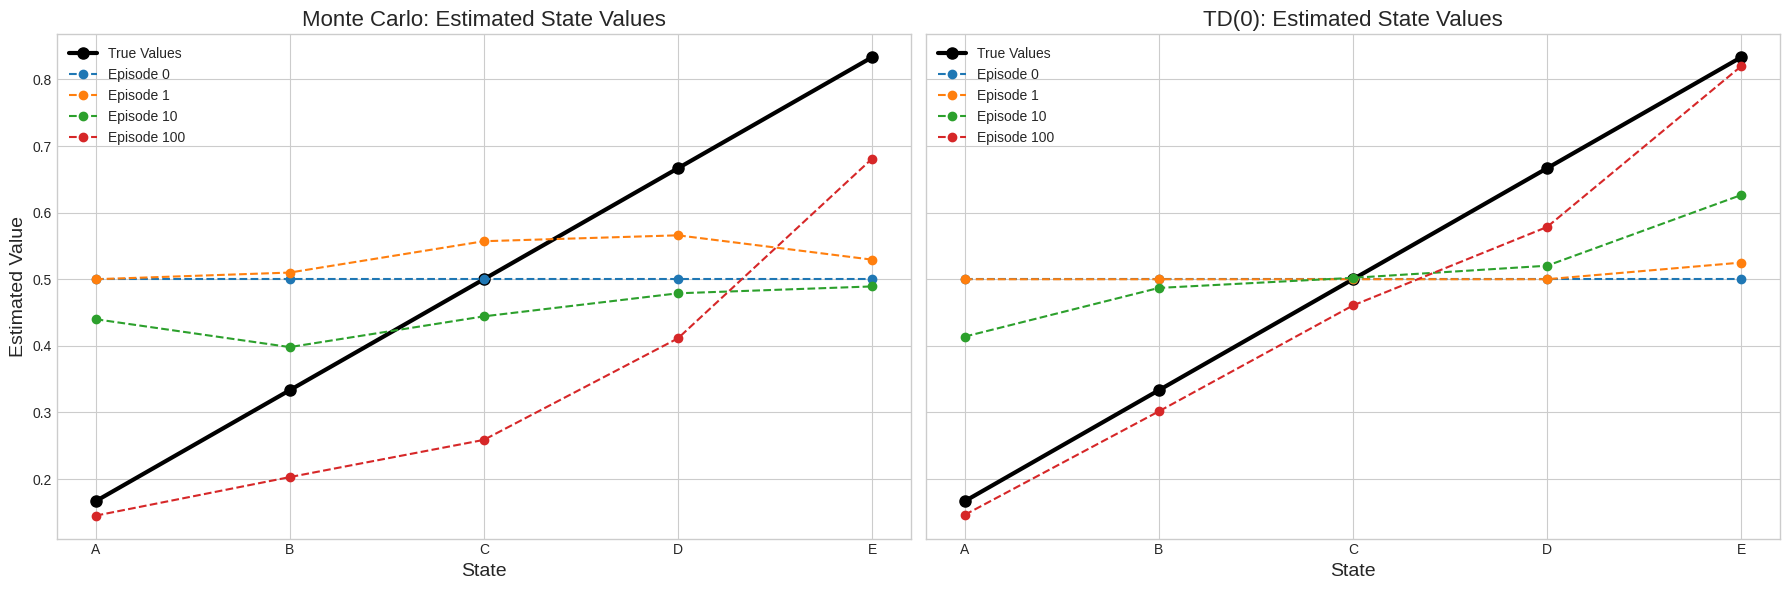


--- Running multiple instances for RMS error comparison ---
This may take a moment...


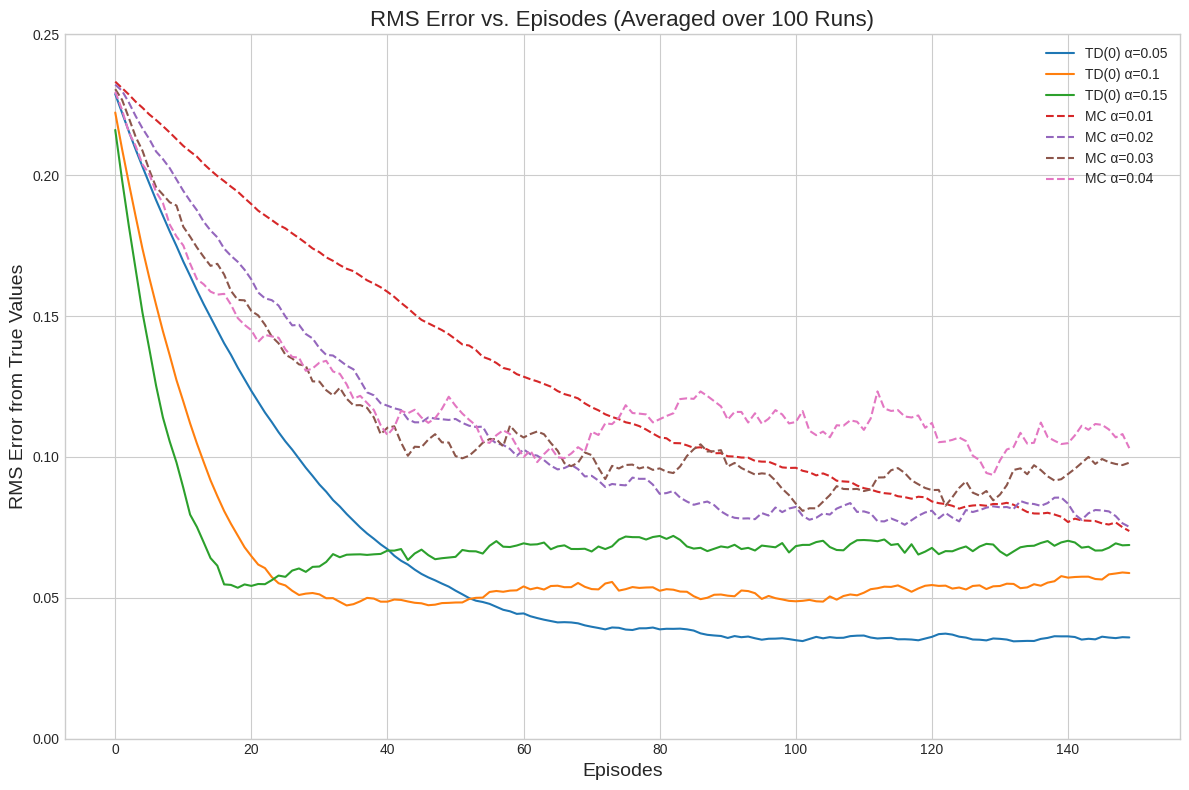

Done.


In [ ]:
if __name__ == '__main__':
    # Initialize the environment
    mrp_env = RandomWalkMRP()

    # --- Part 1: Run a single instance and show value function snapshots ---
    print('--- Running single instance for value function snapshots ---')
    episodes_for_snapshot = 101
    mc_alpha_single = 0.02
    td_alpha_single = 0.05

    final_v_mc, history_mc = monte_carlo_prediction(
        mrp_env, episodes_for_snapshot, alpha=mc_alpha_single
    )
    final_v_td, history_td = td_0_prediction(
        mrp_env, episodes_for_snapshot, alpha=td_alpha_single
    )

    print("\nTrue State Values:")
    for label, val in zip(mrp_env.state_labels, mrp_env.true_values):
        print(f"  V({label}) = {val:.4f}")

    print("\nMC Final Estimated Values:")
    for label, val in zip(mrp_env.state_labels, final_v_mc):
        print(f"  V({label}) = {val:.4f}")

    plot_value_snapshots(history_mc, history_td, mrp_env)

    # --- Part 2: Run multiple instancesw for RMS error comparison ---
    print("\n--- Running multiple instances for RMS error comparison ---")
    print("This may take a moment...")
    plot_rmse_comparison(mrp_env)
    print("Done.")

# [02] Task 2. random walk for batch updating & draw the RMS error curve


In [14]:
"""
This script implements and compares Monte Carlo (MC) and Temporal-Difference (TD(0))
prediction algorithms on a simple Random Walk Markov Reward Processes (MRP).

It includes both online (one update per step/episode) and batch-updating
(repeated updates on all data seen so far) versions of the algorithms.

The MRP is defined as follows:
- States: A, B, C, D, E (indexed 0 to 4).
- All episodes start in the center state, C.
- On each step, the agent moves left or right with equal probability (50%).
- Episodes terminate when moving left from state A or right from state E.
- A reward of +1 is given for terminating on the right (from E). All other rewards are 0.
- The true state values are V(s) = (s+1)/6 for s in {A,B,C,D,E}.
"""

class RandomWalkMRP:
    """
    Implements the Random Walk MRP environment.
    States are represented by indices 0 (A) through 4 (E).
    """
    def __init__(self):
        self.num_states = 5
        self.start_state = 2 # state C
        # The true values of states A, B, C, D, E
        self.true_values = np.arange(1, self.num_states + 1) / (self.num_states + 1.0)
        self.state_labels = ['A', 'B', 'C', 'D', 'E']

    def step(self, state):
        """
        Performs one step in the environment from the given state.

        Args:
            state (int): The current state index.

        Returns:
            tuple: A tuple containing (next_state, reward, is_done).
                next_state is an integer, reward is a float, is_done is a boolean.
        """
        if np.random.rand() < 0.5:
            # Move left
            next_state = state - 1
        else:
            # Move right
            next_state = state + 1

        reward = 0
        is_done = False

        if next_state < 0:
            is_done = True
            # Reward remains 0 for terminating on the left
        elif next_state >= self.num_states:
            is_done = True
            reward = 1.0 # Reward is +1 for terminating on the right

        return next_state, reward, is_done

    def generate_episode(self):
        """Generates a single episode and returns the trajectory and final reward."""
        trajectory = []
        state = self.start_state
        is_done = False
        final_reward = 0

        while not is_done:
            trajectory.append(state)
            state, final_reward, is_done = self.step(state)

        return trajectory, final_reward

In [7]:
def monte_carlo_prediction(env, num_episodes, alpha, gamma=1.0):
    """
    Implements the every-visit Monte Carlo prediction algorithm.

    Args:
        env (RandomWalkMRP): The environment.
        num_episodes (int): The number of episodes to run.
        alpha (float): The learning rate.
        gamma (float): The discount factor.

    Returns:
        tuple: A tuple containing the final value function (V) and the history
            of value estimates over episodes.
    """
    # Initialize values: 0 for terminal states, 0.5 for non-terminal
    V = np.full(env.num_states, 0.5)
    value_history = np.zeros((num_episodes, env.num_states))

    for episode in range(num_episodes):
        # Generate a complete episode trajectory
        trajectory = []
        state = env.start_state
        is_done = False

        while not is_done:
            trajectory.append(state)
            next_state, reward, is_done = env.step(state)
            state = next_state

        # The return G is simply the final reward since gamma=1 and rewards are 0 until the end
        G = reward

        # Update values for all states visited in the episode
        for s in trajectory:
            V[s] += alpha * (G - V[s])

        value_history[episode, :] = V.copy()

    return V, value_history

In [8]:
def td_0_prediction(env, num_episodes, alpha, gamma=1.0):
    """
    Implements the TD(0) prediction algorithm.

    Args:
        env (RandomWalkMRP): The environment.
        num_episodes (int): The number of episodes to run.
        alpha (float): The learning rate.
        gamma (float): The discount factor.

    Returns:
        tuple: A tuple containing the final value function (V) and the history
            of value estimates over episodes.
    """
    V = np.full(env.num_states, 0.5)
    value_history = np.zeros((num_episodes, env.num_states))

    for episode in range(num_episodes):
        state = env.start_state
        is_done = False

        while not is_done:
            next_state, reward, is_done = env.step(state)

            # The value of the next state is 0 if it's a terminal state
            v_next = V[next_state] if not is_done else 0.0

            # TD Update: V(s) <- V(s) + alpha * [R + gamma * V(s') - V(s)]
            V[state] += alpha * (reward + gamma * v_next - V[state])

            state = next_state

        value_history[episode, :] = V.copy()

    return V, value_history

In [9]:
def batch_mc_prediction(env, num_episodes, alpha=1e-3, convergence_sweeps=100):
    """
    Implements the batch-updating constant-alpha MC algorithm.
    """
    episodes_batch = []
    errors = np.zeros(num_episodes)

    for i in range(num_episodes):
        trajectory, reward = env.generate_episode()
        episodes_batch.append((trajectory, reward))
        V = np.full(env.num_states, 0.5) # Re-initialize for convergence

        # Repeatedly sweep through the entire batch
        for _ in range(convergence_sweeps):
            for traj, G in episodes_batch:
                for state in traj:
                    V[state] += alpha * (G - V[state])

        # Calculate RMS error after converging on the current batch
        errors[i] = np.sqrt(np.mean((V - env.true_values) ** 2))

    return errors

In [10]:
def batch_td_prediction(env, num_episodes, alpha=1e-3, convergence_sweeps=100):
    """
    Implements the batch-updating TD(0) algorithm.
    """
    transitions_batch = []
    errors = np.zeros(num_episodes)
    gamma = 1.0

    for i in range(num_episodes):
        # Generate one episode and add its transitions to the batch
        state = env.start_state
        is_done = False
        while not is_done:
            next_state, reward, is_done =env.step(state)
            transitions_batch.append((state, reward, next_state, is_done))
            state = next_state

        V = np.full(env.num_states, 0.5) # Re-initialize for convergence

        # Repeatedly sweep through the entire batch
        for _ in range(convergence_sweeps):
            for s, r, s_next, done in transitions_batch:
                v_next = V[s_next] if not done else 0.0
                V[s] += alpha * (r + gamma * v_next - V[s])

        # Calculate RMS error after converging on the current batch
        errors[i] = np.sqrt(np.mean((V - env.true_values) ** 2))

    return errors

In [11]:
def plot_batch_learning_curves(env, num_runs=100, num_episodes=100):
    """
    Runs the batch experiments and plots the learning curves.
    """
    mc_errors = np.zeros((num_runs, num_episodes))
    td_errors = np.zeros((num_runs, num_episodes))

    print(f"Running {num_runs} repetitions for batch experiment...")
    for run in tqdm(range(num_runs)):
        mc_errors[run, :] = batch_mc_prediction(env, num_episodes)
        td_errors[run, :] = batch_td_prediction(env, num_episodes)

    mc_avg_errors = np.mean(mc_errors, axis=0)
    td_avg_errors = np.mean(td_errors, axis=0)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    plt.plot(mc_avg_errors, label='Batch Constant-α MC')
    plt.plot(td_avg_errors, label='Batch TD(0)')

    plt.title('Batch Training Performance on Random Walk MRP', fontsize=16)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('RMS Error (averaged over states and runs)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.25)
    plt.tight_layout()
    plt.show()

In [12]:
from tqdm import tqdm

--- Running Batch-Updating Experiment ---
Running 100 repetitions for batch experiment...


100%|██████████| 100/100 [12:20<00:00,  7.41s/it]


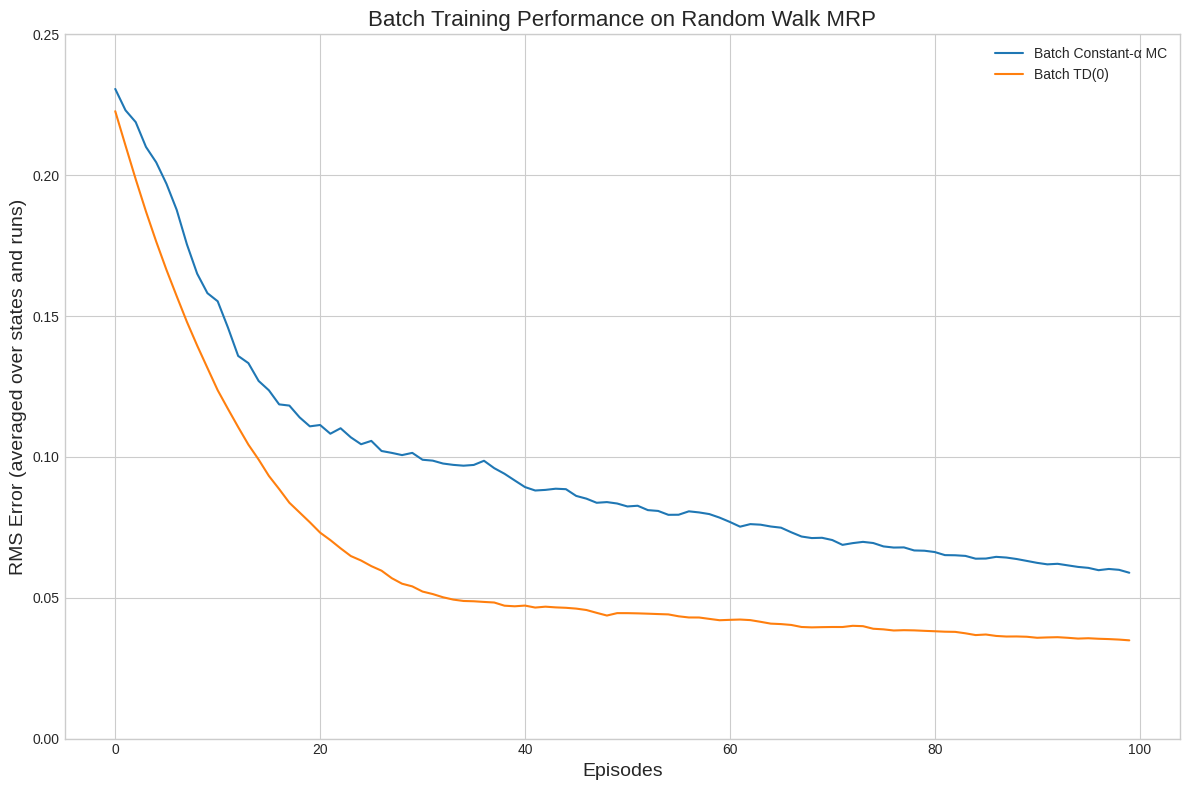

Done.


In [ ]:
if __name__ == '__main__':
    mrp_env = RandomWalkMRP()

    # --- New Experiment: Batch Updating ---
    # This runs the batch experiment as requested in the follow-up.
    # The original online-updating plots can be run by uncommenting the block below.
    print("--- Running Batch-Updating Experiment ---")
    plot_batch_learning_curves(mrp_env, num_runs=100, num_episodes=100)
    print("Done.")

    # --- Original Experiment: Online Updating (Commented Out) ---
    # print("\n--- Running single instance for value function snapshots ---")
    # episodes_for_snapshot = 101
    # mc_alpha_single = 0.02
    # td_alpha_single = 0.05
    # final_v_mc, history_mc = monte_carlo_prediction(
    #     mrp_env, episodes_for_snapshot, alpha=mc_alpha_single
    # )
    # final_v_td, history_td = td_0_prediction(
    #     mrp_env, episodes_for_snapshot, alpha=td_alpha_single
    # )
    # plot_value_snapshots(history_mc, history_td, mrp_env)

    # print("\n--- Running multiple instances for RMS error comparison ---")
    # plot_rmse_comparison(mrp_env)

# [03] Task 3. Number of Walks or Episodes required to evaluate the value of each state with RMS error less than 2%.


In [15]:
def run_batch_until_threshold(env, algorithm, threshold, max_episodes=1000, alpha=1e-3, convergence_sweeps=100):
    """
    Runs a batch algorithm until the RMS error falls below a threshold.

    Args:
        env (RandomWalkMRP): The environment.
        algorithm (str): 'mc' or 'td'.
        threshold (float): The target RMS error.
        max_episodes (int): Maximum episodes to run before giving up.

    Returns:
        int: The number of episodes required to reach the threshold.
    """
    batch = []
    gamma = 1.0

    for episode_num in range(1, max_episodes + 1):
        # Generate data for one episode and add to batch
        if algorithm == 'mc':
            trajectory, reward = env.generate_episode()
            batch.append((trajectory, reward))
        else: # td
            state = env.start_state
            is_done = False
            while not is_done:
                next_state, reward, is_done = env.step(state)
                batch.append((state, reward, next_state, is_done))
                state = next_state

        V = np.full(env.num_states, 0.5) # Re-initialize for convergence

        # Repeatedly sweep through the entire batch to converge V
        for _ in range(convergence_sweeps):
            if algorithm == 'mc':
                for traj, G in batch:
                    for state in traj:
                        V[state] += alpha * (G - V[state])
            else: # td
                for s, r, s_next, done in batch:
                    v_next = V[s_next] if not done else 0.0
                    V[s] += alpha * (r + gamma * v_next - V[s])

        # Check if error is below threshold
        error = np.sqrt(np.mean((V - env.true_values)**2))
        if error < threshold:
            return episode_num

    return max_episodes # Return max if threshold not reached


def analyze_episodes_to_threshold(env, num_runs=100, threshold=0.02):
    """
    Calculates the average number of episodes to reach a given RMS error threshold.
    """
    mc_episodes = []
    td_episodes = []

    print(f"\n--- Analyzing episodes required to reach RMS error < {threshold} ---")
    print(f"Running {num_runs} repetitions...")

    for _ in tqdm(range(num_runs)):
        mc_episodes.append(run_batch_until_threshold(env, 'mc', threshold))
        td_episodes.append(run_batch_until_threshold(env, 'td', threshold))

    avg_mc = np.mean(mc_episodes)
    avg_td = np.mean(td_episodes)

    print("\n--- Results ---")
    print(f"Average episodes for Batch MC to reach < {threshold} RMS error: {avg_mc:.2f}")
    print(f"Average episodes for Batch TD(0) to reach < {threshold} RMS error: {avg_td:.2f}")


def plot_batch_learning_curves(env, num_runs=100, num_episodes=100):
    """
    Runs the batch experiments and plots the learning curves.
    """
    mc_errors = np.zeros((num_runs, num_episodes))
    td_errors = np.zeros((num_runs, num_episodes))

    print(f"--- Running Batch-Updating Experiment (Learning Curves) ---")
    print(f"Running {num_runs} repetitions for batch experiment...")
    for run in tqdm(range(num_runs)):
        mc_errors[run, :] = batch_mc_prediction(env, num_episodes)
        td_errors[run, :] = batch_td_prediction(env, num_episodes)

    mc_avg_errors = np.mean(mc_errors, axis=0)
    td_avg_errors = np.mean(td_errors, axis=0)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    plt.plot(mc_avg_errors, label='Batch Constant-α MC')
    plt.plot(td_avg_errors, label='Batch TD(0)')

    plt.title('Batch Training Performance on Random Walk MRP', fontsize=16)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('RMS Error (averaged over states and runs)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.25)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    mrp_env = RandomWalkMRP()

    # --- New Analysis: Episodes to reach 2% error threshold ---
    analyze_episodes_to_threshold(mrp_env, num_runs=100, threshold=0.02)

    # --- Previous Experiment: Batch Updating Learning Curves (Commented out) ---
    # plot_batch_learning_curves(mrp_env, num_runs=100, num_episodes=100)

    print("\nDone.")


--- Analyzing episodes required to reach RMS error < 0.02 ---
Running 100 repetitions...


100%|██████████| 100/100 [1:21:10<00:00, 48.70s/it]


--- Results ---
Average episodes for Batch MC to reach < 0.02 RMS error: 239.82
Average episodes for Batch TD(0) to reach < 0.02 RMS error: 142.10

Done.
